<a href="https://colab.research.google.com/github/SofiNurul/JWD_Tugas3/blob/main/Salinan_dari_KAMUS_LEXICON_ANALISIS_SENTIMEN_ULASAN_PRODUK_PENGHILANG_BEKAS_LUKA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

---




In [1]:
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support

Mengunduh resource nltk yang diperlukan



In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **Information Extraction (IE) & Information Retrieval (IR) : Import Dataset**

---



Muat dataset

In [3]:
# Memuat dataset
df = pd.read_csv('data_kotor.csv', encoding='MacRoman')
# Menampilkan 5 data teratas dan 5 data terakhir
df_combined = pd.concat([df.head(5), df.tail(5)], axis=0)
# Menampilkan hasil
df_combined

,username,date,content,score
0,z*****e,10/10/2024,Pertama kali coba karena baca ulasan di Quora ...,4
1,dindardew,03/09/2024,Penasaran bgt dari dulu udah laser jg bekas lu...,5
2,dikamungil,03/09/2024,"Udah ku pke beberapa kali sih, semoga bermanfa...",5
3,cakranouval,11/08/2024,"kecewa, kemasan penyok",3
4,ilhamansyari22,18/06/2024,Barang sesuai pesanan √¢Àú¬∫√Ø¬∏¬è,5
1169,Pengguna Shopee,10/10/2019,Bismillah semoga cocok guys. Ini sepertinya ha...,5
1170,faizarik22,09/10/2019,Masih mau nyobak sih. Soon mungkin 1 tahun ked...,5
1171,faratania,30/09/2019,Respon cepat. Produk superrrr bagusssss. Ini u...,5
1172,ayanara_,21/09/2019,"Ini seriusan pesen tanggal 20, trus tgl 21 uda...",5
1173,yuanrayi05,14/03/2019,Udh Beli 2x alhamdulillah Ada hasilnya Dan dpt...,5


# **Natural Language Processing (NLP)**

---




Pembersihan teks

In [4]:
# Fungsi untuk membersihkan teks
def clean_text(teks):
    if not isinstance(teks, str):
        return ""
    teks = teks.lower()
    teks = re.sub(r'http\S+|www\S+|https\S+', '', teks)  # Menghapus URL
    teks = re.sub(r'[^\x00-\x7F]+', ' ', teks)  # Menghilangkan karakter non-ASCII
    teks = teks.translate(str.maketrans('', '', string.punctuation))  # Menghapus tanda baca
    teks = re.sub(r'\d+', '', teks)  # Menghapus angka
    return teks

# Fungsi untuk tokenisasi
def tokenize(teks):
    return teks.split()

# Fungsi untuk menghapus stopwords
def remove_stopwords(tokens, stopwords_set):
    return [word for word in tokens if word not in stopwords_set]

# Fungsi untuk stemming
def apply_stemming(tokens, stemmer):
    return [stemmer.stem(token) for token in tokens]

# Fungsi untuk menjalankan semua tahapan preprocessing
def preprocess_text(teks, stopwords_set, stemmer):
    cleaned_text = clean_text(teks)               # Membersihkan teks
    tokens = tokenize(cleaned_text)               # Tokenisasi
    filtered_tokens = remove_stopwords(tokens, stopwords_set)  # Menghapus stopwords
    stemmed_tokens = apply_stemming(filtered_tokens, stemmer)  # Melakukan stemming
    return {
        "cleaned_text": cleaned_text,
        "tokens": tokens,
        "filtered_tokens": filtered_tokens,
        "stemmed_tokens": stemmed_tokens
    }

Inisialisasi Stopwords dan Stemmer

In [5]:
stopwords_tambahan = set([
    'gk', 'yg', 'nya', 'dan', 'dll', 'saja', 'juga', 'untuk', 'dengan', 'atau',
    'tapi', 'karena', 'seperti', 'yang', 'saya', 'ga', 'malah', 'tidak', 'lagi',
    'ini', 'di', 'kok', 'aja', 'gak', 'jadi', 'ya', 'dah', 'bisa', 'ada', 'bgt',
    'banget', 'kak', 'ituu', 'grgr', 'jd', 'pengen', 'dgn', 'udah', 'klo', 'tp',
    'pa', 'udh', 'karin', 'bgtt', 'ig', 'po', 'tau', 'utk', 'karna', 'brangnya',
    'ngk', 'kyk', 'sy', 'tp', 'uda', 'nga', 'dngn', 'kalo', 'gamau', 'becak', 'kya',
    'sma', 'jdi', 'ad', 'lg', 'pa', 'huhu', 'dpt', 'gel', 'b', 'jg', 'rb', 'hehe',
    'pdhl', 'dr', 'ku', 'sih', 'ka', 'kyk', 'sy', 'bli', 'skali', 'dikrim', 'berharap',
    'kirim', 'jdi', 'pkai', 'penjual', 'brangnya', 'becak', 'tpi', 'blum', 'bgin','aku','beli','ya','ini','ga','udah','di',
])
nltk_stopwords = set(stopwords.words('indonesian'))  # Mengambil stopwords dari NLTK
final_stopwords = nltk_stopwords.union(stopwords_tambahan)  # Menggabungkan stopwords NLTK dengan tambahan

# Membuat objek stemmer
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.6 MB/s eta 0:00:00


Proses Preprocessing Data

In [6]:
df_selected = df[['content']]

# Terapkan preprocessing
processed_data = df_selected['content'].apply(
    lambda x: preprocess_text(x, final_stopwords, stemmer)
)

Tambahkan kolom hasil preprocessing ke DataFrame

In [7]:
# Menambahkan kolom ke DataFrame
df['cleaned_text'] = processed_data.apply(lambda x: x['cleaned_text'])
df['tokens'] = processed_data.apply(lambda x: x['tokens'])
df['filtered_tokens'] = processed_data.apply(lambda x: x['filtered_tokens'])
df['stemmed_tokens'] = processed_data.apply(lambda x: x['stemmed_tokens'])

# Mengatur tampilan Pandas agar teks ditampilkan penuh
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

# Menampilkan tabel hasil preprocessing (10 baris teratas)
df_subset = df[['content', 'cleaned_text', 'tokens', 'filtered_tokens', 'stemmed_tokens']].head(10)

# Menggunakan Pandas Styler untuk menampilkan tabel
styled_table = df_subset.style.set_properties(**{
    'text-align': 'left'  # Atur teks agar rata kiri
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]  # Atur header kolom agar rata kiri
}])

# Tampilkan tabel
from IPython.display import display
display(styled_table)

,content,cleaned_text,tokens,filtered_tokens,stemmed_tokens
0,"Pertama kali coba karena baca ulasan di Quora katanya bagus, semoga ngefek bekas2 korengan pas hamil anak ke 2 memudar, hasilnya pemakaian 1 botol insyaallah akan aku update ya.. kalo emang bagus pasti repurchase (beli lagi) di toko ini, Sellernya ramah dan amanah.. suka kalo di chat gercep di balas gak pake lama, pengiriman ke Jakarta juga cepat.",pertama kali coba karena baca ulasan di quora katanya bagus semoga ngefek bekas korengan pas hamil anak ke memudar hasilnya pemakaian botol insyaallah akan aku update ya kalo emang bagus pasti repurchase beli lagi di toko ini sellernya ramah dan amanah suka kalo di chat gercep di balas gak pake lama pengiriman ke jakarta juga cepat,"['pertama', 'kali', 'coba', 'karena', 'baca', 'ulasan', 'di', 'quora', 'katanya', 'bagus', 'semoga', 'ngefek', 'bekas', 'korengan', 'pas', 'hamil', 'anak', 'ke', 'memudar', 'hasilnya', 'pemakaian', 'botol', 'insyaallah', 'akan', 'aku', 'update', 'ya', 'kalo', 'emang', 'bagus', 'pasti', 'repurchase', 'beli', 'lagi', 'di', 'toko', 'ini', 'sellernya', 'ramah', 'dan', 'amanah', 'suka', 'kalo', 'di', 'chat', 'gercep', 'di', 'balas', 'gak', 'pake', 'lama', 'pengiriman', 'ke', 'jakarta', 'juga', 'cepat']","['kali', 'coba', 'baca', 'ulasan', 'quora', 'bagus', 'semoga', 'ngefek', 'bekas', 'korengan', 'pas', 'hamil', 'anak', 'memudar', 'hasilnya', 'pemakaian', 'botol', 'insyaallah', 'update', 'emang', 'bagus', 'repurchase', 'toko', 'sellernya', 'ramah', 'amanah', 'suka', 'chat', 'gercep', 'balas', 'pake', 'pengiriman', 'jakarta', 'cepat']","['kali', 'coba', 'baca', 'ulas', 'quora', 'bagus', 'moga', 'ngefek', 'bekas', 'koreng', 'pas', 'hamil', 'anak', 'pudar', 'hasil', 'pakai', 'botol', 'insyaallah', 'update', 'emang', 'bagus', 'repurchase', 'toko', 'sellernya', 'ramah', 'amanah', 'suka', 'chat', 'gercep', 'balas', 'pake', 'kirim', 'jakarta', 'cepat']"
1,Penasaran bgt dari dulu udah laser jg bekas luka gak ilang Nemu produk ini jadi coba aja dulu siapa tau cocok order 2 langsung kk,penasaran bgt dari dulu udah laser jg bekas luka gak ilang nemu produk ini jadi coba aja dulu siapa tau cocok order langsung kk,"['penasaran', 'bgt', 'dari', 'dulu', 'udah', 'laser', 'jg', 'bekas', 'luka', 'gak', 'ilang', 'nemu', 'produk', 'ini', 'jadi', 'coba', 'aja', 'dulu', 'siapa', 'tau', 'cocok', 'order', 'langsung', 'kk']","['penasaran', 'laser', 'bekas', 'luka', 'ilang', 'nemu', 'produk', 'coba', 'cocok', 'order', 'langsung', 'kk']","['penasaran', 'laser', 'bekas', 'luka', 'ilang', 'nemu', 'produk', 'coba', 'cocok', 'order', 'langsung', 'kk']"
2,"Udah ku pke beberapa kali sih, semoga bermanfaat. Makasih ya seller. Harganya mahal tp semoga ampuuuuh yaaaa",udah ku pke beberapa kali sih semoga bermanfaat makasih ya seller harganya mahal tp semoga ampuuuuh yaaaa,"['udah', 'ku', 'pke', 'beberapa', 'kali', 'sih', 'semoga', 'bermanfaat', 'makasih', 'ya', 'seller', 'harganya', 'mahal', 'tp', 'semoga', 'ampuuuuh', 'yaaaa']","['pke', 'kali', 'semoga', 'bermanfaat', 'makasih', 'seller', 'harganya', 'mahal', 'semoga', 'ampuuuuh', 'yaaaa']","['pke', 'kali', 'moga', 'manfaat', 'makasih', 'seller', 'harga', 'mahal', 'moga', 'ampuuuuh', 'yaaaa']"
3,"kecewa, kemasan penyok",kecewa kemasan penyok,"['kecewa', 'kemasan', 'penyok']","['kecewa', 'kemasan', 'penyok']","['kecewa', 'kemas', 'penyok']"
4,Barang sesuai pesanan √¢Àú¬∫√Ø¬∏¬è,barang sesuai pesanan,"['barang', 'sesuai', 'pesanan']","['barang', 'sesuai', 'pesanan']","['barang', 'sesuai', 'pesan']"
5,Baru pertama kali coba mudah mudahan bisa pudar bekas keloid nya Maksih semoga berkah Kalau cocok bakal beli lagi Maaf ya kk fotonya gak sesuai,baru pertama kali coba mudah mudahan bisa pudar bekas keloid nya maksih semoga berkah kalau cocok bakal beli lagi maaf ya kk fotonya gak sesuai,"['baru', 'pertama', 'kali', 'coba', 'mudah', 'mudahan', 'bisa', 'pudar', 'bekas', 'keloid', 'nya', 'maksih', 'semoga', 'berkah', 'kalau', 'cocok', 'bakal', 'beli', 'lagi', 'maaf', 'ya', 'kk', 'fotonya', '

In [8]:
import os

# Simpan hasil preprocessing ke file CSV
output_file = "hasil_preprocessing.csv"
df_selected.to_csv(output_file, index=False)

print(f"Hasil preprocessing telah disimpan ke file: {os.path.abspath(output_file)}")

Hasil preprocessing telah disimpan ke file: /content/hasil_preprocessing.csv


# **CLUSTERING**

---



Tranformasi Data Menjadi Fitur Numerik


=== Hasil Klasifikasi Sentimen untuk 300 Data Pertama ===
|    | stemmed_tokens                                                                                                                                                                                                                                                                                                              |   polarity_score | sentiment   |
|---:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------:|:------------|
|  0 | ['kali', 'coba', 'baca', 'ulas', 'quora', 'bagus', 'moga', 'ngefek', 'bekas', 'koreng', 'pas', 'hamil', 'anak', 'pudar', 'hasil', 'pakai', 'botol', 'insyaallah', 'update', 'emang', 'bagus', 'repurchase', 'toko', 'selle

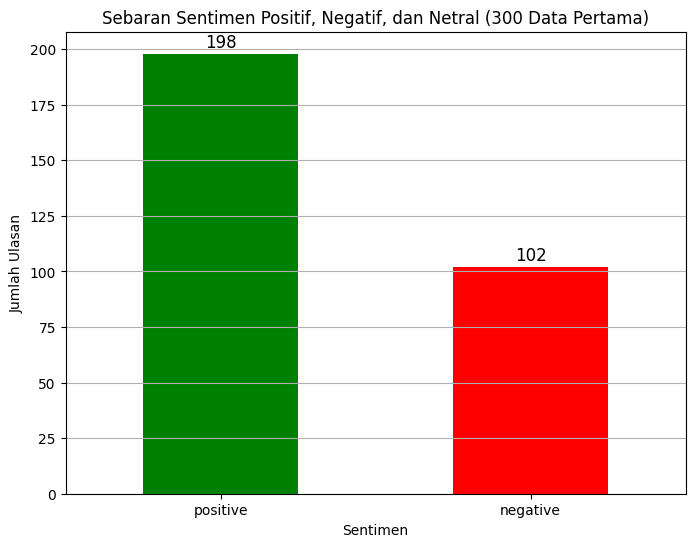

In [112]:
# Fungsi untuk menghitung skor polaritas
def calculate_polarity_score(words):
    score = 0
    for word in words:  # Iterasi langsung pada setiap kata dalam daftar
        if word in positive_dict:
            score += positive_dict[word]  # Tambahkan bobot dari kamus positif
        elif word in negative_dict:
            score += negative_dict[word]  # Tambahkan bobot dari kamus negatif
    return score

# Fungsi untuk memberi label sentimen berdasarkan skor polaritas
def label_sentiment(score):
    if score >= 5:
        return 'positive'
    else:
        return 'negative'

# Terapkan fungsi hanya pada 300 data pertama
df['processed_text'] = df['stemmed_tokens'].apply(lambda tokens: ' '.join(tokens))  # Gabungkan kembali menjadi string
df['polarity_score'] = df['stemmed_tokens'].apply(calculate_polarity_score)  # Hitung skor polaritas

# Terapkan label sentimen hanya pada 300 data pertama
df.loc[:299, 'sentiment'] = df.loc[:299, 'polarity_score'].apply(label_sentiment)

# Menampilkan hasil
print("\n=== Hasil Klasifikasi Sentimen untuk 300 Data Pertama ===")
print(df[['stemmed_tokens', 'polarity_score', 'sentiment']].head(50).to_markdown())

# Visualisasi sebaran sentimen untuk 300 data pertama
sentiment_counts = df.loc[:299, 'sentiment'].value_counts()

plt.figure(figsize=(8, 6))
ax = sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])  # Tambahkan warna untuk sentimen netral jika ada

# Menambahkan angka di atas batang
for idx, value in enumerate(sentiment_counts):
    plt.text(idx, value + 1, str(value), ha='center', va='bottom', fontsize=12)

plt.title("Sebaran Sentimen Positif, Negatif, dan Netral (300 Data Pertama)")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Ulasan")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


# **Categorization : Klasifikasi Algortima Naive Bayes**

---



Transformasi Data

In [118]:
# Pastikan stopwords_tambahan diubah menjadi list
stopwords_tambahan = list(stopwords_tambahan)

# TRANSFORMASI TF-IDF UNTUK KESELURUHAN DATA
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_df=0.75,
    min_df=3,
    stop_words=stopwords_tambahan,
    max_features=5000
)

X_all = vectorizer.fit_transform(df['cleaned_text'])

# MENAMPILKAN HASIL TF-IDF PADA BEBERAPA ULASAN SECARA ACAK
random_samples = df.sample(10, random_state=42)
random_indices = random_samples.index

# Ambil TF-IDF dari ulasan-ulasannya
feature_names = vectorizer.get_feature_names_out()
random_tfidf = X_all[random_indices].toarray()

# Tampilkan hasil TF-IDF dalam bentuk DataFrame
tfidf_sample_df = pd.DataFrame(random_tfidf, columns=feature_names, index=random_samples.index)

# Tampilkan beberapa hasil TF-IDF
print("\n=== TF-IDF untuk 10 Ulasan Acak ===")
print(tfidf_sample_df.iloc[:, :10])  # Hanya menampilkan 10 fitur pertama untuk ringkasan

# SIMPAN TF-IDF KE FILE CSV
tfidf_sample_df.to_csv('tfidf_samples.csv', index=False)
print("\nHasil TF-IDF untuk ulasan acak telah disimpan dalam file 'tfidf_samples.csv'.")



=== TF-IDF untuk 10 Ulasan Acak ===
      aamiin  abis  adain  adain promo  adha  admin  adminnya  after  afternya  aga
410      0.0   0.0    0.0          0.0   0.0    0.0       0.0    0.0       0.0  0.0
430      0.0   0.0    0.0          0.0   0.0    0.0       0.0    0.0       0.0  0.0
675      0.0   0.0    0.0          0.0   0.0    0.0       0.0    0.0       0.0  0.0
208      0.0   0.0    0.0          0.0   0.0    0.0       0.0    0.0       0.0  0.0
811      0.0   0.0    0.0          0.0   0.0    0.0       0.0    0.0       0.0  0.0
665      0.0   0.0    0.0          0.0   0.0    0.0       0.0    0.0       0.0  0.0
1066     0.0   0.0    0.0          0.0   0.0    0.0       0.0    0.0       0.0  0.0
832      0.0   0.0    0.0          0.0   0.0    0.0       0.0    0.0       0.0  0.0
58       0.0   0.0    0.0          0.0   0.0    0.0       0.0    0.0       0.0  0.0
1107     0.0   0.0    0.0          0.0   0.0    0.0       0.0    0.0       0.0  0.0

Hasil TF-IDF untuk ulasan acak telah d

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


Pelatihan Model Naive Bayes

In [125]:
# Pastikan kolom 'sentiment' sudah ada
if 'sentiment' not in df.columns:
    df['sentiment'] = df['polarity_score'].apply(lambda x: 'positive' if x >= 5 else 'negative')
df_selected['sentiment'] = df['sentiment']

#Pembagian Data Latih(sudah diberi label) dan data Uji (belum diberi label)
df_labeled = df_selected[df_selected['sentiment'].notna()]
df_unlabeled = df_selected[df_selected['sentiment'].isna()]
X_labeled = X_all[:len(df_labeled)]
X_unlabeled = X_all[len(df_labeled):]
y_labeled = df_labeled['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X_labeled, y_labeled, test_size=0.2, random_state=42, stratify=y_labeled
)

#Latih Model dengan Hyperparameter Tuning
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print("\nBest Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Parameters: {'alpha': 0.5}


<ipython-input-125-cc6a4fa7560e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['sentiment'] = df['sentiment']


Prediksi Model

In [126]:
#Prediksi Pada Data Uji(belum Berlabel) dan Menggabungkannya dengan Data Latih(sudah berlabel)
y_pred_unlabeled = best_model.predict(X_unlabeled)

df_unlabeled.loc[:, 'predicted_sentiment'] = y_pred_unlabeled
df_labeled.loc[:, 'predicted_sentiment'] = df_labeled['sentiment']

df_combined = pd.concat([df_labeled, df_unlabeled], ignore_index=True)



<ipython-input-126-2072eab6a16d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unlabeled.loc[:, 'predicted_sentiment'] = y_pred_unlabeled
<ipython-input-126-2072eab6a16d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labeled.loc[:, 'predicted_sentiment'] = df_labeled['sentiment']


Pelatihan Ulang Pada Data Gabungan

In [128]:
# Pastikan df_combined memiliki kolom 'cleaned_text'
if 'cleaned_text' not in df_combined.columns:
    # Tambahkan kolom 'cleaned_text' jika tidak ada
    df_combined['cleaned_text'] = df_combined['content'].apply(clean_text)

# Pastikan 'cleaned_text' tersedia
if 'cleaned_text' not in df_combined.columns:
    df_combined['cleaned_text'] = df_combined['content'].apply(clean_text)

# Pastikan 'predicted_sentiment' tersedia
if 'predicted_sentiment' not in df_combined.columns:
    df_combined['predicted_sentiment'] = df_combined['polarity_score'].apply(
        lambda x: 'positive' if x >= 5 else 'negative'
    )

# Transformasi data dengan vectorizer
X_combined = vectorizer.transform(df_combined['cleaned_text'])
y_combined = df_combined['predicted_sentiment']

# Bagi data menjadi train dan test
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined
)

#LATIH MODEL ULANG DENGAN DATA GABUNGAN
model_combined = MultinomialNB(alpha=grid_search.best_params_['alpha'])
model_combined.fit(X_train_combined, y_train_combined)

y_pred_combined_test = model_combined.predict(X_test_combined)

print("\n=== Evaluation on Combined Data ===")
print(classification_report(y_test_combined, y_pred_combined_test))


=== Evaluation on Combined Data ===
              precision    recall  f1-score   support

    negative       0.78      0.19      0.30        37
    positive       0.87      0.99      0.92       198

    accuracy                           0.86       235
   macro avg       0.82      0.59      0.61       235
weighted avg       0.85      0.86      0.83       235



# **Visualization**

---



Confusion Matrix

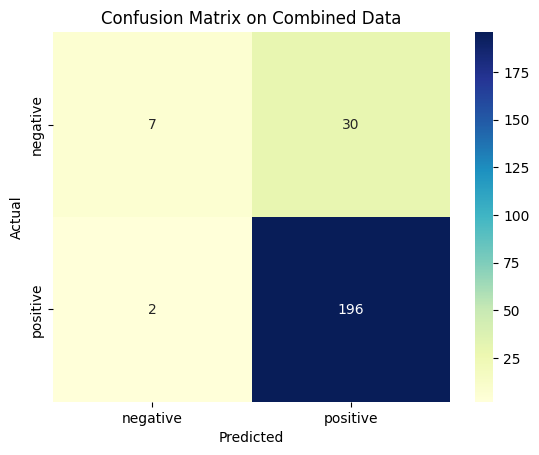

In [129]:
cm_combined = confusion_matrix(y_test_combined, y_pred_combined_test)
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='YlGnBu', xticklabels=model_combined.classes_, yticklabels=model_combined.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Combined Data')
plt.show()


In [130]:
df_combined.to_csv('data_gabungan_terprediksi.csv', index=False)
print("\nData gabungan dengan prediksi telah disimpan dalam file 'data_gabungan_terprediksi.csv'.")


Data gabungan dengan prediksi telah disimpan dalam file 'data_gabungan_terprediksi.csv'.


<ipython-input-131-4943bf7a3e48>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=axes[0], palette=['#66c2a5', '#fc8d62', '#8da0cb'], hue=None)
<ipython-input-131-4943bf7a3e48>:8: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=axes[0], palette=['#66c2a5', '#fc8d62', '#8da0cb'], hue=None)


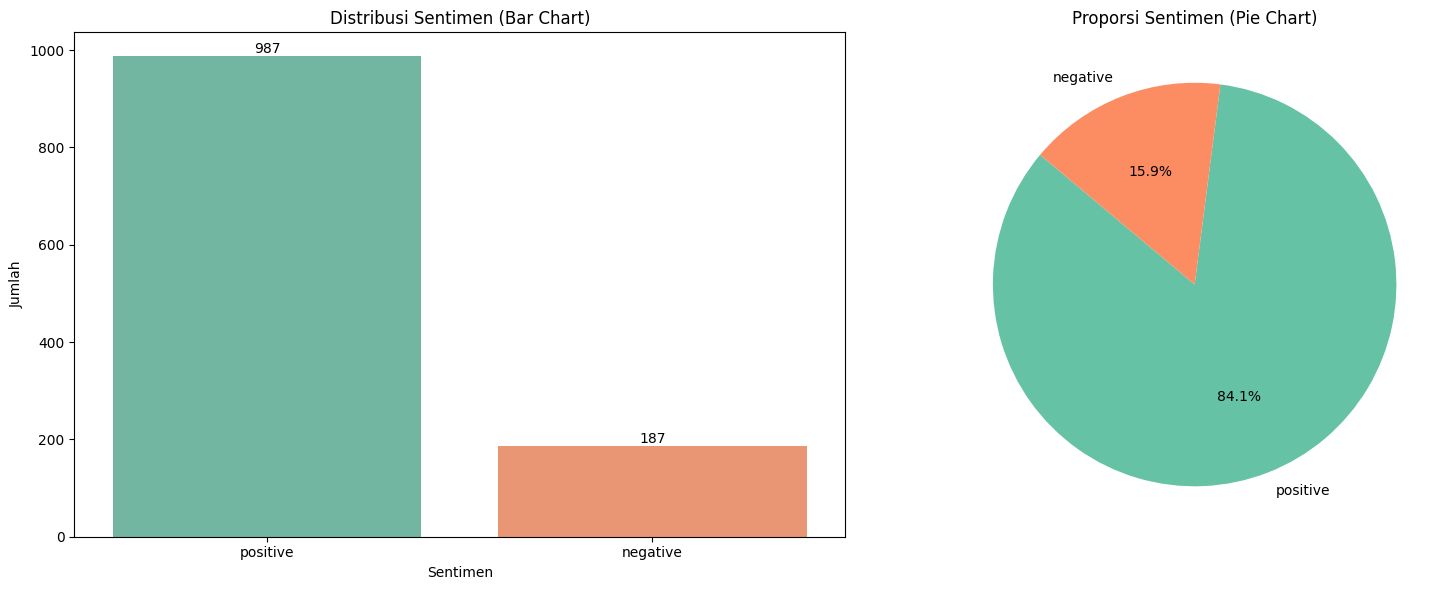

In [131]:
# Visualisasi Distribusi Sentimen Gabungan pada Keseluruhan Data
def visualize_sentiment_distribution_full(df, sentiment_col):
    # Hitung jumlah masing-masing sentimen
    sentiment_counts = df[sentiment_col].value_counts()

    # Bar Chart
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=axes[0], palette=['#66c2a5', '#fc8d62', '#8da0cb'], hue=None)
    axes[0].set_xlabel("Sentimen")
    axes[0].set_ylabel("Jumlah")
    axes[0].set_title("Distribusi Sentimen (Bar Chart)")

    # Tambahkan angka di atas batang
    for index, value in enumerate(sentiment_counts.values):
        axes[0].text(index, value, str(value), ha="center", va="bottom")

    # Pie Chart
    axes[1].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140,
                colors=['#66c2a5', '#fc8d62', '#8da0cb'])
    axes[1].set_title("Proporsi Sentimen (Pie Chart)")

    # Menyesuaikan layout
    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk visualisasi
visualize_sentiment_distribution_full(df_combined, sentiment_col='predicted_sentiment')


WORDCLOUD UNTUK SETIAP SENTIMEN

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Sentimen yang tersedia: ['positive' 'negative']


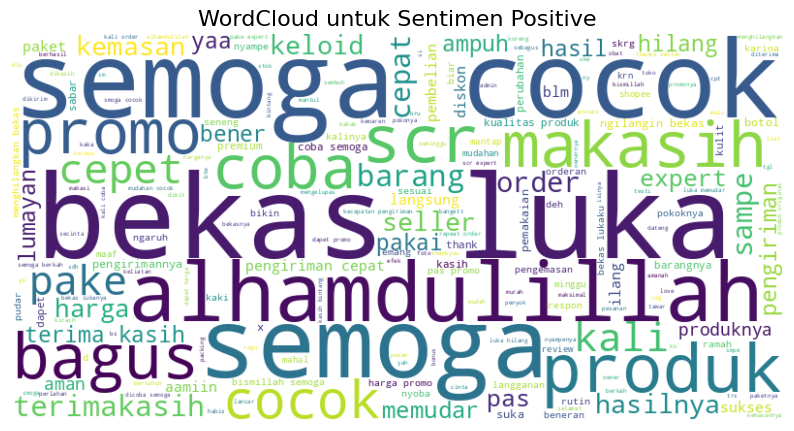

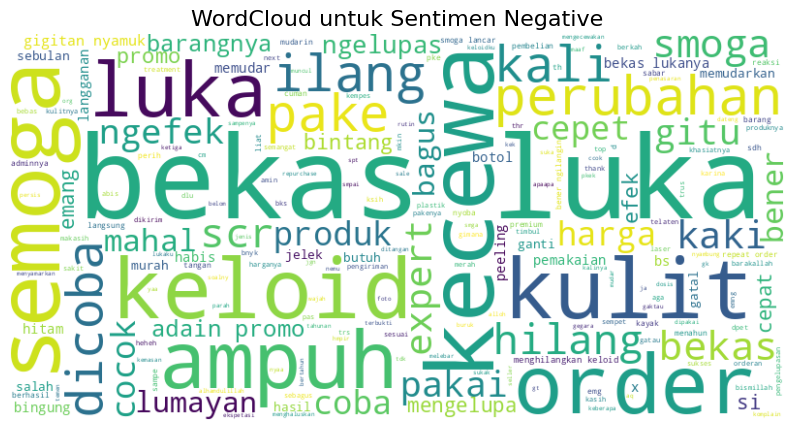

In [132]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Daftar stopwords (gabungan stopword NLTK dan tambahan)
stopwords_tambahan = set(stopwords.words('indonesian') + [
    'tapi', 'karena', 'seperti', 'yang', 'saya', 'ga', 'malah', 'tidak', 'lagi',
    'ini', 'di', 'kok', 'aja', 'gak', 'jadi', 'ya', 'dah', 'bisa', 'ada', 'bgt',
    'banget', 'kak', 'ituu', 'grgr', 'jd', 'pengen', 'dgn', 'udah', 'klo', 'tp',
    'pa', 'udh', 'karin', 'bgtt', 'ig', 'po', 'tau', 'utk', 'karna', 'brangnya',
    'ngk', 'kyk', 'sy', 'tp', 'uda', 'nga', 'dngn', 'kalo', 'gamau', 'becak', 'kya',
    'sma', 'jdi', 'ad', 'lg', 'pa', 'huhu', 'dpt', 'gel', 'b', 'jg', 'rb', 'hehe',
    'pdhl', 'dr', 'ku', 'sih', 'ka', 'kyk', 'sy', 'bli', 'skali', 'dikrim', 'berharap',
    'kirim', 'jdi', 'pkai', 'penjual', 'brangnya', 'becak', 'tpi', 'blum', 'bgin', 'aku', 'beli', 'ya', 'ini', 'ga', 'udah', 'di', 'nya', 'yg'
])

# Fungsi untuk membuat dan menampilkan WordCloud berdasarkan sentimen
def generate_wordcloud(df, sentiment_value, sentiment_col, text_col):
    # Filter data untuk sentimen tertentu
    filtered_text = " ".join(df[df[sentiment_col] == sentiment_value][text_col].astype(str))

    # Jika tidak ada data untuk sentimen ini, abaikan
    if not filtered_text.strip():
        print(f"Tidak ada data untuk sentimen '{sentiment_value}'. WordCloud tidak akan dibuat.")
        return

    # Hapus kata-kata yang ada di daftar stopwords
    filtered_text = " ".join(word for word in filtered_text.split() if word not in stopwords_tambahan)

    # Buat WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(filtered_text)

    # Plot WordCloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud untuk Sentimen {sentiment_value.capitalize()}", fontsize=16)
    plt.show()

# Perbarui daftar sentimen sesuai dengan nilai yang ada
sentiments = ['positive', 'negative']  # Nilai sesuai data Anda
print("Sentimen yang tersedia:", df_combined['predicted_sentiment'].unique())
for sentiment in sentiments:
    generate_wordcloud(df_combined, sentiment_value=sentiment, sentiment_col='predicted_sentiment', text_col='cleaned_text')
